In [1]:
import gammapy 
print(f'loaded gammapy version: {gammapy.__version__} ' )
print(f'Supposed to be 1.0 (21-12-2022)' )

loaded gammapy version: 0.1.dev19174+g56b5bdf 
Supposed to be 1.0 (21-12-2022)


In [2]:
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

In [3]:
#get_ipython().system('jupyter nbconvert --to script 1-Nui_Par_Fitting.ipynb')
import pyximport

pyximport.install()
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
import gammapy

# from gammapy.datasets import MapDataset
from gammapy.maps import Map
from  scipy.interpolate import interp2d
from astropy.coordinates import SkyCoord, Angle
from gammapy.modeling import Fit, Parameter, Parameters, Covariance
from gammapy.datasets import MapDataset #, MapDatasetNuisance
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    create_crab_spectral_model,
    SkyModel,
    PointSpatialModel,
    ShellSpatialModel,
    GeneralizedGaussianSpatialModel,
    TemplateSpatialModel,
    LogParabolaSpectralModel,
    GaussianSpatialModel,
    DiskSpatialModel,
    PowerLawNormSpectralModel,
    Models,
    SpatialModel,
    FoVBackgroundModel,
)
from gammapy.estimators import TSMapEstimator, ExcessMapEstimator

from regions import CircleSkyRegion, RectangleSkyRegion
import yaml
import sys

#sys.path.append(
#    "/home/hpc/caph/mppi045h/3D_analysis/N_parameters_in_L/syserror_3d_bkgmodel/4-Fitting_nuisance_and_model_parameters"
#)
#from my_dataset_maps_20 import MapDatasetNuisance
#from MapDatasetNuisanceE import MapDatasetNuisanceE
#from  my_fit_20 import Fit
sys.path.append('../../../')
from Dataset_Creation import sys_dataset
import Dataset_load

In [4]:
config = Dataset_load.load_config()
colors = config['colors']['one']

## Read dataset

In [ ]:
scaled_amplitude = Parameter('amplitude', 
                             value = 1e-12)
cutoff = 60
cutoff_input_value = cutoff
lambda_ = Parameter('lambda_', value = 1/ cutoff )
dataset_asimov  = Dataset_load.create_asimov(model = 'ecpl',source = "PKSflare",
                                            parameters = Parameters([scaled_amplitude, lambda_]))


loaded dataset:
/home/wecapstor1/caph/mppi045h/nuisance_summary/PKS_flare/HESS_public/dataset-simulated-ecpl.fits.gz


## Varying the Exposure

In [ ]:
savefig = True
picformat = 'png'

bias = 0.1
res = 0.1
print(bias)


0.1


In [7]:


sys_ = sys_dataset(dataset_asimov= dataset_asimov,
                        shift = 0, 
                        tilt = 0,
                        bias = 0,
                        resolution = 0,
                        rnd = False,
                        e_reco_creation=10)
dataset_asimov = sys_.create_dataset()
dataset_asimov_N = sys_.create_dataset_N(e_reco_n=10)
zero = 1e-24
## addional parameter bias and resolution (ereco) but are frozen
penalising_invcovmatrix = np.zeros((4, 4))
#'bias', 'resolution', 'norm_nuisance',  'tilt_nuisance',
np.fill_diagonal(penalising_invcovmatrix,
                 [1/bias**2, 1/res**2, 1/zero**2, 1/zero**2])
dataset_asimov_N.penalising_invcovmatrix = penalising_invcovmatrix


In [8]:
%%time
fit_cor = Fit(store_trace=False)
minuit_opts = {"tol": 0.001, "strategy": 2}
fit_cor.optimize_opts = minuit_opts
result_cor = fit_cor.run([dataset_asimov])  

CPU times: user 41.1 s, sys: 12.9 s, total: 54.1 s
Wall time: 54.2 s


In [9]:
%%time
fitting = 0
if fitting:
    fit_cor_N = Fit(store_trace=False)
    result_cor = fit_cor_N.run([dataset_asimov_N]) 
else:
    path = f'data/2_model_nui_0.0_cutoff_{cutoff_input_value}.yml'
    dataset_asimov_N = Dataset_load.load_dataset_N(dataset_asimov_N, path)        
    


CPU times: user 81.1 ms, sys: 50.9 ms, total: 132 ms
Wall time: 133 ms


In [10]:
dataset_asimov_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3000e+00,,1.671e-01,nan,nan,False,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,5.822e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spectral,lambda_,1.6667e-02,TeV-1,1.444e-02,nan,nan,False,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,False,


In [11]:
dataset_asimov_N.models[-1].parameters['norm_nuisance'].frozen = True
dataset_asimov_N.models[-1].parameters['tilt_nuisance'].frozen = True

In [12]:
dataset_asimov.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3014e+00,,7.029e-02,nan,nan,False,False,False,
spectral,amplitude,9.9986e-13,cm-2 s-1 TeV-1,5.457e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spectral,lambda_,1.6169e-02,TeV-1,1.382e-02,nan,nan,False,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,False,


In [13]:
dataset_asimov_N.models[0].spectral_model.parameters.to_table()

type,name,value,unit,error,min,max,frozen,is_norm,is_penalised,link
str8,str9,float64,str14,float64,float64,float64,bool,bool,bool,str1
spectral,index,2.3000e+00,,1.671e-01,nan,nan,False,False,False,
spectral,amplitude,1.0000e-12,cm-2 s-1 TeV-1,5.822e-14,nan,nan,False,True,False,
spectral,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,False,
spectral,lambda_,1.6667e-02,TeV-1,1.444e-02,nan,nan,False,False,False,
spectral,alpha,1.0000e+00,,0.000e+00,nan,nan,True,False,False,


### Import Rnd

In [14]:
import os
path = os.getcwd() +'/'
infos = np.loadtxt(path + "data/7a_P_draw_info.txt")
pars = np.loadtxt(path + "data/7a_P_draw_par.txt")
flux = np.loadtxt(path + "data/7a_P_draw_flux.txt")
flux2e = np.loadtxt(path + "data/7a_P_draw_flux2e.txt")


lem = len(infos)
N_max = 1000
N = np.min([lem, N_max])

print(N)
shift_rnds = infos[:N_max,0]
index_rnds = infos[:N_max,1]
stat_sums = infos[:N_max,2]


#amplitude', 'index', 'norm', 'tilt
lambda_ = pars[:N_max,0:2]
indices = pars[:N_max,2:4] 
norms = pars[:N_max,4:6]
tilts = pars[:N_max,6:8]



31


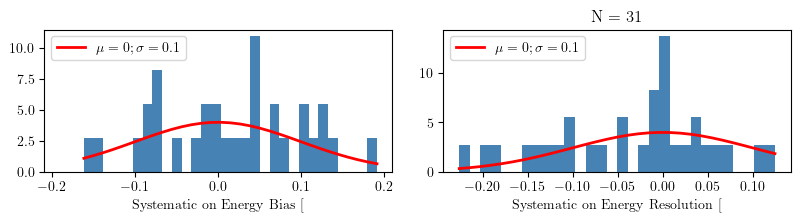

In [16]:
fig, (axs, ax1) = plt.subplots(1,2, figsize = (2*4,7/3))
nbins = 30
count, bins, ignored = axs.hist(shift_rnds, nbins, density=True, color = 'steelblue')
sigma =res
mu = 0
axs.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma}$')

axs.set_xlabel("Systematic on Energy Bias [%]")
axs.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)


count, bins, ignored = ax1.hist(index_rnds, nbins, density=True, color = 'steelblue')
sigma =bias
mu = 0
ax1.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
               np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
         linewidth=2, color='r', label = f'$\mu = {mu}; \sigma = {sigma:.3}$')

ax1.set_xlabel("Systematic on Energy Resolution [%]")
ax1.set_title(f"N = {N}")
ax1.legend()

x = axs.get_xlim()
deltax = np.max([ mu - x[0] , x[1] - mu ])
axs.set_xlim(mu -deltax, 
                mu + deltax)
plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_rnd_sys_{bias}." + picformat)   
    


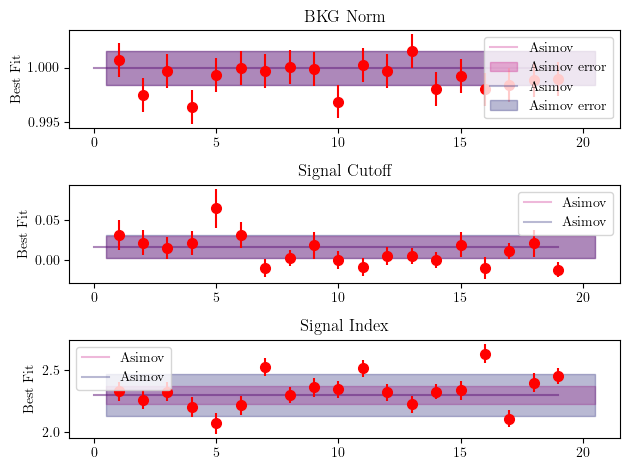

In [18]:
fig, axs = plt.subplots(3,1)

axs[0].set_title("BKG Norm")
axs[1].set_title("Signal Cutoff")
axs[2].set_title("Signal Index")

N_plot = 20
labels = [ '-10%', '0%', '10%']


for i, d in enumerate([dataset_asimov, dataset_asimov_N]):
    
    best = d.models[1].parameters['norm'].value
    er = d.models[1].parameters['norm'].error
    axs[0].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")
    axs[0].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3,
                        label = "Asimov error")
    
    best = d.models[0].parameters['lambda_'].value
    er = d.models[0].parameters['lambda_'].error 
    axs[1].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3)
    axs[1].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")

    best = d.models[0].parameters['index'].value
    er = d.models[0].parameters['index'].error
    axs[2].fill_betweenx( [best-er , best + er], 0.5, N_plot+0.5, color  = colors[i], alpha = 0.3)
    axs[2].plot( [best] * N_plot, color  = colors[i], alpha = 0.3, label = "Asimov")

for i, a in enumerate(norms[1:N_plot]):
    axs[0].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[0].hlines( norms[0][0], 1, N, label = "input", color = 'black')


for i, a in enumerate(lambda_[1:N_plot]):
    axs[1].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[1].hlines( 60, 1, N_plot, label = "input", color ='black')


for i, a in enumerate(indices[1:N_plot]):
    axs[2].errorbar(x= i+1, y = a[0], yerr = a[1], fmt= 'o', color =  'red',markersize=7)
#axs[2].hlines( indices[0][0], 1, N, label = "input", color ='black')



plt.tight_layout()
for a in axs:
    a.legend(); 
    a.set_ylabel('Best Fit'); 

plt.tight_layout()    
#if savefig:
#    fig.savefig(f"plots/7b_best_fit_{factor}_{N}.pdf")   


In [26]:

valuies = [norms, lambda_, indices]

valuies_asimov = [[dataset_asimov.models[1].parameters['norm'].value, 
                   dataset_asimov.models[1].parameters['norm'].error],
                  [dataset_asimov.models[0].parameters['lambda_'].value, 
                   dataset_asimov.models[0].parameters['lambda_'].error],
                  [dataset_asimov.models[0].parameters['index'].value, 
                   dataset_asimov.models[0].parameters['index'].error],]


valuies_asimov_N = [[dataset_asimov_N.models[1].parameters['norm'].value, 
                   dataset_asimov_N.models[1].parameters['norm'].error],
                  [dataset_asimov_N.models[0].parameters['lambda_'].value, 
                   dataset_asimov_N.models[0].parameters['lambda_'].error],
                  [dataset_asimov_N.models[0].parameters['index'].value, 
                   dataset_asimov_N.models[0].parameters['index'].error],]
is_within_norm = []
is_within_lambdas = []
is_within_index = []
is_within_norm_N = []
is_within_lambdas_N = []
is_within_index_N = []

i = 0
for n in norms:
    larger = np.all(n[0] >= (valuies_asimov[0][0] - valuies_asimov[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov[0][0] + valuies_asimov[0][1]))
    is_within_norm.append(larger and smaller)
    
    larger = np.all(n[0] >= (valuies_asimov_N[0][0] - valuies_asimov_N[0][1]))
    smaller = np.all(n[0] <= (valuies_asimov_N[0][0] + valuies_asimov_N[0][1]))
    is_within_norm_N.append(larger and smaller)
    
for a in lambda_:
    larger = np.all(a[0] >= (valuies_asimov[1][0] - valuies_asimov[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov[1][0] + valuies_asimov[1][1]))
    is_within_lambdas.append(larger and smaller)
    
    larger = np.all(a[0] >= (valuies_asimov_N[1][0] - valuies_asimov_N[1][1]))
    smaller = np.all(a[0] <= (valuies_asimov_N[1][0] + valuies_asimov_N[1][1]))
    is_within_lambdas_N.append(larger and smaller)
    
for i in indices:
    larger = np.all(i[0] >= (valuies_asimov[2][0] - valuies_asimov[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov[2][0] + valuies_asimov[2][1]))
    is_within_index.append(larger and smaller)
    
    larger = np.all(i[0] >= (valuies_asimov_N[2][0] - valuies_asimov_N[2][1]))
    smaller = np.all(i[0] <= (valuies_asimov_N[2][0] + valuies_asimov_N[2][1]))
    is_within_index_N.append(larger and smaller)
    
within_norm = [np.count_nonzero(is_within_norm)/N,
              np.count_nonzero(is_within_norm_N)/N]

within_lambdas = [np.count_nonzero(is_within_lambdas)/N,
              np.count_nonzero(is_within_lambdas_N)/N]

within_index = [np.count_nonzero(is_within_index)/N,
              np.count_nonzero(is_within_index_N )/N]

withins = [within_norm, 
          within_lambdas,
          within_index]

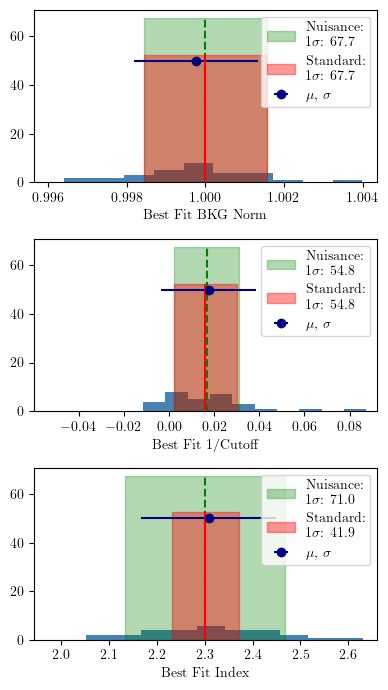

In [38]:
fig, axs = plt.subplots(3,1, figsize = (4,7))
xlabels = ["Best Fit BKG Norm", "Best Fit 1/Cutoff", "Best Fit Index"]

axs[2].errorbar(x = np.mean(indices[:,0]) ,y = 50, xerr = np.std(indices[:,0]), fmt='o', 
                color = 'navy', label = "$\mu$, $\sigma$")
axs[1].errorbar(x = np.mean(lambda_[:,0]) ,y = 50, xerr = np.std(lambda_[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
axs[0].errorbar(x = np.mean(norms[:,0]) ,y = 50, xerr = np.std(norms[:,0]), fmt='o',
               color = 'navy', label = "$\mu$, $\sigma$")
    

for i, v in enumerate(valuies):
    axs[i].hist(v[1:,0], color ='steelblue')
    ylim = axs[i].get_ylim()
    delta_ylim = 15
    
    axs[i].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = 'green', 
                 linestyle= 'dashed', )
    axs[i].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.3, color = 'green', 
                        label = f'Nuisance: \n 1$\sigma$: {withins[i][1]*100 :.3}%')
    axs[i].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = 'red')
    axs[i].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.4 , color = 'red',  
                        label = f'Standard: \n 1$\sigma$: {withins[i][0]*100 :.3}%'  )
    
    axs[i].legend(loc = 'upper right')  
    axs[i].set_xlabel(xlabels[i])  
    
    
    x = axs[i].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[i].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_histo_{bias}."+ picformat)

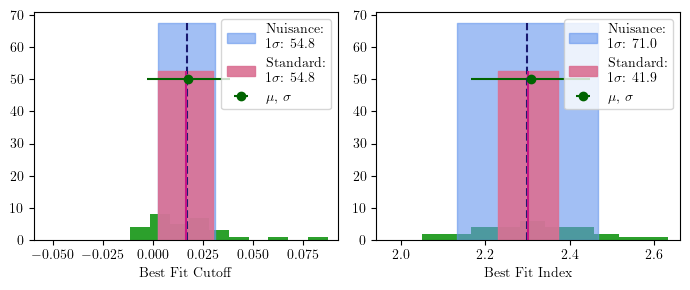

In [31]:
fig, axs = plt.subplots(1,2, figsize = (7,3))
xlabels = ["Best Fit Cutoff", "Best Fit Index"]

axs[1].errorbar(x = np.mean(indices[:,0]) ,y = 50, xerr = np.std(indices[:,0]), fmt='o', 
                color = 'darkgreen', label = "$\mu$, $\sigma$")
axs[0].errorbar(x = np.mean(lambda_[:,0]) ,y = 50, xerr = np.std(lambda_[:,0]), fmt='o',
               color = 'darkgreen', label = "$\mu$, $\sigma$")
    
i = 1
for p, v in enumerate(valuies[1:]):
    
    axs[p].hist(v[1:,0], color ='tab:green')
    ylim = axs[p].get_ylim()
    delta_ylim = 15

    axs[p].vlines(valuies_asimov_N[i][0], ylim[0], ylim[1]+ delta_ylim, color = colors[1], 
                 linestyle= 'dashed', )
    axs[p].fill_between([valuies_asimov_N[i][0] - valuies_asimov_N[i][1],
                         valuies_asimov_N[i][0] + valuies_asimov_N[i][1]]
                        , ylim[0], ylim[1]+ delta_ylim,
                       alpha = 0.6, color = colors[3], 
                        label = f'Nuisance: \n 1$\sigma$: {withins[i][1]*100 :.3}%')
    axs[p].vlines(valuies_asimov[i][0], ylim[0], ylim[1], color = colors[0])
    axs[p].fill_between([valuies_asimov[i][0] - valuies_asimov[i][1],
                         valuies_asimov[i][0] + valuies_asimov[i][1]]
                        , ylim[0], ylim[1],
                       alpha = 0.9 , color = colors[2], 
                        label = f'Standard: \n 1$\sigma$: {withins[i][0]*100 :.3}%'  )

    axs[p].legend(loc = 'upper right')  
    axs[p].set_xlabel(xlabels[p])  


    x = axs[p].get_xlim()
    deltax = np.max([ valuies_asimov[i][0] - x[0] , x[1] - valuies_asimov[i][0] ])
    axs[p].set_xlim(valuies_asimov[i][0] -deltax, 
                    valuies_asimov[i][0] + deltax)
    #axs[p].set_yscale('log')
    i+=1

plt.tight_layout()

if savefig:
    fig.savefig(f"plots/7b_histo_{bias}."+ picformat)

In [32]:
mask = dataset_asimov.mask.data.sum(axis=2).sum(axis=1)>0
ebins = dataset_asimov.counts.geom.axes[0].center[mask]
asimov, asimov_errors = dataset_asimov.models[0].spectral_model.evaluate_error(ebins)
asimov_N, asimov_errors_N = dataset_asimov_N.models[0].spectral_model.evaluate_error(ebins)


In [33]:
withine = []
withine_N = []

for ie, e in enumerate(ebins):
    xs = []
    xs_N = []
    for f in flux:
        value = f[ie]   
        lowerlim = (np.all(value <= asimov.value[ie] + asimov_errors.value[ie]))
        upperlim = (np.all(value >= asimov.value[ie] - asimov_errors.value[ie]))
        x = lowerlim & upperlim
        xs.append(x)
        
        lowerlim = (np.all(value <= asimov_N.value[ie] + asimov_errors_N.value[ie]))
        upperlim = (np.all(value >= asimov_N.value[ie] - asimov_errors_N.value[ie]))
        x = lowerlim & upperlim
        xs_N.append(x)
        
        
    withine.append(np.count_nonzero(xs) / N)
    withine_N.append(np.count_nonzero(xs_N) / N)


In [34]:
mean = flux2e.mean(axis = 0)
std = flux2e.std(axis = 0)

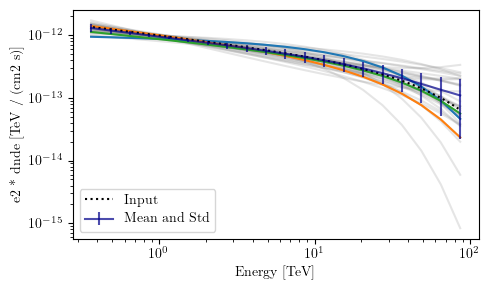

In [35]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
fig, axs = plt.subplots(1,1,figsize = (5,3) )
for i, f in enumerate(flux2e):
    axs.plot(ebins, f, color = 'grey', alpha = 0.2)#10/N)
for i, f in enumerate(flux2e[:3]):
    axs.plot(ebins, f,)
axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
            label = "Mean and Std")

dataset_asimov.models[0].spectral_model.plot(energy_bounds, linestyle=':', energy_power = 2, ax = axs,
                                label = "Input", color = "black", )
axs.legend()
axs.set_xlabel("Energy [TeV]")
plt.tight_layout()
#if savefig:
#    fig.savefig(f"plots/7b_rnd_spectra_{shift}_{N}." + picformat)

In [36]:
def compute_precision(N):
    Z = 1.645
    return  Z / np.sqrt(N)

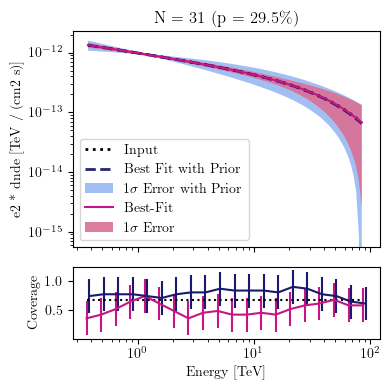

In [37]:
true_energy = dataset_asimov.exposure.geom.axes[0].center.value
energy_bounds = (ebins[0] , ebins[-1] ) *u.TeV
energy_power = 2
fig, (axs, ax2) = plt.subplots(2,1, gridspec_kw={'height_ratios': [3, 1]},
                         sharex = True, figsize = ((4,4)))
#axs.errorbar(ebins, mean, yerr = std,  color = 'darkblue', alpha = 0.7,
#            label = "Mean and Std")
dataset_asimov.models[0].spectral_model.plot(energy_bounds, energy_power = energy_power, ax =axs, 
                                label = "Input", color = 'black', linewidth = energy_power, linestyle="dotted")
dataset_asimov_N.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,color = colors[1],
                                                         label="Best Fit with Prior",
                                                        alpha = 0.95,
                                                       linestyle='dashed', linewidth= 2)
dataset_asimov_N.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                        facecolor=colors[3],
                                                         label="$1\sigma$ Error with Prior",
                                                        alpha = 0.6)

dataset_asimov.models[0].spectral_model.plot(energy_bounds,  energy_power = energy_power, ax = axs,
                                label = "Best-Fit", color = colors[0])
dataset_asimov.models[0].spectral_model.plot_error(energy_bounds,  energy_power = energy_power, ax = axs,
                                                       facecolor=colors[2],
                                                          alpha = 0.9,
                                                          label= "$1\sigma$ Error"
                                                         )
p = compute_precision(N)
ax2.errorbar(ebins, withine, yerr = p,  color =  colors[0], label = f"")
ax2.errorbar(ebins*1.05, withine_N, yerr = p , color =  colors[1], label = "")
ax2.plot(ebins, [0.68] * len(ebins), ':', color = 'black', label = "")

axs.set_xlabel('')
axs.legend()
#ax2.legend(ncol = 2)
axs.set_title(f"N = {N} (p = {p*100:.3}\%)")
ax2.set_xlabel('Energy [TeV]')
ax2.set_ylabel('Coverage')

plt.tight_layout()
if savefig:
    fig.savefig(f"plots/7b_spectra_{bias}." + picformat)
    fig.savefig(f"plots/7b_spectra_{bias}." + "pdf")
    
